In [4]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
cs = [colours[i] for i in range(len(colours))]
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [5]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    df = df.sort_values(by='time_of_arrival', ignore_index=True)
    return df

In [6]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [7]:
for route in routes:
    add_extra_data(route)

In [8]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [9]:
new_6 = pd.read_csv("data/6 09-06-20.csv")
new_52 = pd.read_csv("data/52 09-06-20.csv")
new_9 = pd.read_csv("data/9 09-06-20.csv")

new_6.head()

,vehicle_id,bus_stop_id,time_of_arrival,time_of_req,direction
0,10623_490003256N_2020-05-17_inbound_0,490003256N,2020-05-17 17:19:04,2020-05-17 17:19:17.892,inbound
1,10623_490006108E_2020-05-17_inbound_0,490006108E,2020-05-17 17:20:01,2020-05-17 17:19:24.951,inbound
2,10636_490006471E_2020-05-17_outbound_0,490006471E,2020-05-17 17:19:30,2020-05-17 17:19:27.03,outbound
3,10285_490013046M_2020-05-17_outbound_0,490013046M,2020-05-17 17:19:58,2020-05-17 17:19:36.662,outbound
4,11485_490000186A_2020-05-17_inbound_0,490000186A,2020-05-17 17:20:09,2020-05-17 17:19:37.928,inbound


In [10]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7


HTTPError: HTTP Error 404: Not Found

In [11]:
stops_452 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_452.csv")
stops_52 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_52.csv")
stops_7 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_7.csv")
stops_14 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_14.csv")
stops_9 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_9.csv")
stops_328 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_328.csv")
stops_69 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_69.csv")
stops_35 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_35.csv")
stops_37 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_37.csv")
stops_267 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_267.csv")
stops_277 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_277.csv")
stops_6 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_6.csv")

stops = {}
stops["452"] = stops_452
stops["52"] = stops_52
stops["7"] = stops_7
stops["9"] = stops_9
stops["14"] = stops_14
stops["328"] = stops_328
stops["267"] = stops_267
stops["277"] = stops_277
stops["35"] = stops_35
stops["37"] = stops_37
stops["69"] = stops_69
stops["6"] = stops_6

In [12]:
tfl_predictions = pd.read_csv("data-collection/tfl preds/tfl_predictions.csv")
tfl_predictions.head()

,start_stop,end_stop,time_of_req,pred_jrny_time
0,Willesden Bus Garage,Okehampton Road,2020-06-01 14:45:00+00:00,0:07:39
1,Willesden Bus Garage,Harrow Road / Kilburn Lane,2020-06-01 14:45:00+00:00,0:11:41
2,Willesden Bus Garage,Chesterton Road,2020-06-01 14:45:00+00:00,0:17:52
3,Willesden Bus Garage,Notting Hill Gate Station,2020-06-01 14:45:00+00:00,0:25:13
4,Chesterton Road,Notting Hill Gate Station,2020-06-01 14:45:00+00:00,0:07:21


# Data Analytics

## Helper Functions

In [13]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [14]:
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

In [15]:
# Generate list of request times at minutes interval
def generate_request_times(minutes, start, end):
    """
    minutes: frequency of request times e.g. every 15 minutes
    start: start time
    end: end time
    num_times: the number of times to generate
    """
    start = convert_time_to_datetime(start)
    end = convert_time_to_datetime(end)
    req_times = [start]
    
    while start <= end:
        new_time = start + dt.timedelta(minutes = minutes)
        req_times.append(new_time)
        start = new_time
        
    format = '%Y-%m-%d %H:%M:%S'
    req_times_str = [t.strftime(format) for t in req_times]
    return req_times_str

## Predict journey time by taking recent information into account 

### Route 52 Gap of 5: Chesterton Road to Nottinghill Gate Station (inbound)

I am at Chesterton Road and I want to know how long it will take my bus to get to Nottinghill Gate Station. The current time is X.

1) **Looking back different amounts of time**

- I look at the other buses that have left Chesterton Road and arrived at Nottinghill Gate Station in the past x hours. Weight it so that the journey times in the past 10 minutes weight more than journey times in the past 20 minutes, 20 minutes more than 40 minutes, 40 minutes more than 80 minutes and 80 minutes more than 120 minutes. (Obviously depends on how far back we look, between 15 minutes to 2 hours). Then calculate this weighted average as the predicted journey time for a bus travelling between Chesterton Road and Nottinghill Gate. **predicted journey time = weighted average of past x hours of journey times**

2) **Looking back different numbers of buses**

- I look at the past x buses that have left Chesterton Road and arrived at Nottinghill Gate Station. Weight it so that the journey times for the more recent buses weight more than the journey times of the less recent buses. What counts as 'recent' depends on how many buses back we are looking.

I look for the last bus to leave Chesterton Road and arrive at Nottinghill Gate before the request time. Then I get the next immediate bus that leaves Chesterton Road. This is the one that will be used to predict the arrival time. Add the predicted journey time onto the leave time of this bus + 30 seconds loading/unloading time to get the predicted arrival time. **predicted arrival time = leave time + predicted journey time + 30 seconds**. 

If such a bus doesn't exist, then there is no predicted arrival time, but there is still the predicted journey time. E.g. if I request the time that the nearest bus will arrive at Nottinghill Gate at 03:16:27, then I gather all the buses that arrived at Nottinghill Gate within the past 2 hours that arrived BEFORE 03:16:27. Say the last bus that left Chesterton Road left at 02:45 and arrived at Nottinghill Gate at 03:15. So to get the predicted arrival time, I try to find the next bus to leave Chesterton Road, which is a bus that leaves at 03:17. This time is AFTER the request time so I cannot use this bus in the prediction because it is not the historical data.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds. This can be adjusted to see varying accuracy?

I now get the actual arrival time. The same bus that we used to calculate the predicted arrival time, we track its vehicle id in the entries for Nottinghill Gate and look for its actual arrival time. Get the actual journey time by subtracting the leave time from the actual arrival time. **actual journey time = actual arrival time - leave time**

To evaluate success, plot the predicted journey journey time against the actual journey time and could calculate the MAPE or something along those lines.

In [16]:
stop_a_name52 = stops_in_sequence_inbound.get("52")[16]
stop_b_name52 = stops_in_sequence_inbound.get("52")[21]

print(stop_a_name52, stops_in_sequence_inbound.get("52").index("Chesterton Road"))
print(stop_b_name52, stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

Chesterton Road 16
Notting Hill Gate Station 21


In [17]:
temp_52_a = new_52.loc[(new_52['bus_stop_id'] == '490005139C') & (new_52['direction'] == 'inbound')]
temp_52_a['bus_stop_name'] = "Chesterton Road"
temp_52_a = temp_52_a.drop(columns = "bus_stop_id")

temp_52_b = new_52.loc[(new_52['bus_stop_id'] == '490000167G') & (new_52['direction'] == 'inbound')]
temp_52_b['bus_stop_name'] = "Notting Hill Gate Station"
temp_52_b = temp_52_b.drop(columns = "bus_stop_id")

temp_52_b.head()

/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,vehicle_id,time_of_arrival,time_of_req,direction,bus_stop_name
25,19399_490000167G_2020-05-17_inbound_0,2020-05-17 05:56:51,2020-05-17 05:55:46.856,inbound,Notting Hill Gate Station
102,19673_490000167G_2020-05-17_inbound_0,2020-05-17 06:09:08,2020-05-17 06:08:59.781,inbound,Notting Hill Gate Station
173,19391_490000167G_2020-05-17_inbound_0,2020-05-17 06:21:30,2020-05-17 06:04:35.092,inbound,Notting Hill Gate Station
227,11530_490000167G_2020-05-17_inbound_0,2020-05-17 06:31:55,2020-05-17 06:22:05.661,inbound,Notting Hill Gate Station
270,10267_490000167G_2020-05-17_inbound_0,2020-05-17 06:40:32,2020-05-17 06:37:50.207,inbound,Notting Hill Gate Station


In [18]:
b_52 = data["52"]

stop_a52 = b_52.loc[(b_52['bus_stop_name'] == stop_a_name52) & (b_52['direction'] == 'inbound')]

xid = stops_52.loc[(stops_52['stop_name'] == stop_a_name52) & (stops_52['direction'] == 'inbound')]
xid = xid.get('stop_id').values[0]
print("inbound id: ", xid)

[_, stop_a_id52, _, _, _] = stop_a52.iloc[0]['vehicle_id'].split('_')
print(stop_a52.shape)
print("found id: ", stop_a_id52)
stop_a52 = temp_52_a
stop_a52.head()

inbound id:  490005139C
(1351, 5)
found id:  490005139C


,vehicle_id,time_of_arrival,time_of_req,direction,bus_stop_name
7,19399_490005139C_2020-05-17_inbound_0,2020-05-17 05:52:05,2020-05-17 05:47:40.674,inbound,Chesterton Road
82,19673_490005139C_2020-05-17_inbound_0,2020-05-17 06:05:39,2020-05-17 06:00:28.35,inbound,Chesterton Road
161,19391_490005139C_2020-05-17_inbound_0,2020-05-17 06:17:43,2020-05-17 06:14:26.016,inbound,Chesterton Road
193,11530_490005139C_2020-05-17_inbound_0,2020-05-17 06:28:01,2020-05-17 06:27:23.223,inbound,Chesterton Road
256,10267_490005139C_2020-05-17_inbound_0,2020-05-17 06:36:51,2020-05-17 06:36:07.528,inbound,Chesterton Road


In [19]:
stop_b52 = b_52.loc[(b_52['bus_stop_name'] == stop_b_name52) & (b_52['direction'] == 'inbound')]

xid = stops_52.loc[(stops_52['stop_name'] == stop_b_name52) & (stops_52['direction'] == 'inbound')]
xid = xid.get('stop_id').values[0]
print("inbound id: ", xid)

[_, stop_b_id52, _, _, _] = stop_b52.iloc[0]['vehicle_id'].split('_')
print(stop_b52.shape)
# outbound id
print("found id: ", stop_b_id52)
stop_b52 = temp_52_b
stop_b52.head()

inbound id:  490015039C
(1360, 5)
found id:  490000167G


,vehicle_id,time_of_arrival,time_of_req,direction,bus_stop_name
25,19399_490000167G_2020-05-17_inbound_0,2020-05-17 05:56:51,2020-05-17 05:55:46.856,inbound,Notting Hill Gate Station
102,19673_490000167G_2020-05-17_inbound_0,2020-05-17 06:09:08,2020-05-17 06:08:59.781,inbound,Notting Hill Gate Station
173,19391_490000167G_2020-05-17_inbound_0,2020-05-17 06:21:30,2020-05-17 06:04:35.092,inbound,Notting Hill Gate Station
227,11530_490000167G_2020-05-17_inbound_0,2020-05-17 06:31:55,2020-05-17 06:22:05.661,inbound,Notting Hill Gate Station
270,10267_490000167G_2020-05-17_inbound_0,2020-05-17 06:40:32,2020-05-17 06:37:50.207,inbound,Notting Hill Gate Station


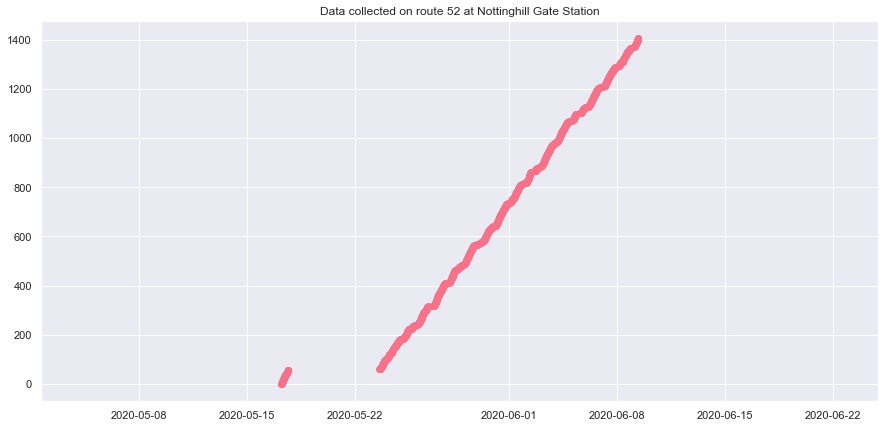

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
x = [convert_time_to_datetime(i) for i in stop_b52['time_of_arrival']]
ax.scatter(x, [i for i in range(0, len(x))])
# ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 5, 10, 22, 59, 59)])
ax.set_title("Data collected on route 52 at Nottinghill Gate Station")
plt.show()

In [65]:
def predict_arrival_time(req_time, leave_stop, pred_jrny_time, most_recent_left):
    """
    Params
    - req_time: the time of request
    - leave_stop: stop that is being used to find the bus to track i.e. stop_a
    - pred_jrny_time: predicted journey time
    - most_recent_left: the index of the bus that left leave_stop the last but
    arrived at stop_a before the request time.
    
    Returns
    - the predicted arrival time of the bus at stop B
    - the actual vehicle that is being tracked.
    """
    
    req_time = convert_time_to_datetime(req_time)

    for i, bus in leave_stop.iterrows():
        
        if i > most_recent_left:
            # Ensures that it will arrive at stop b either ON or AFTER req_time
            leave_time = convert_time_to_datetime(bus['time_of_arrival'])
            # This vehicle is the one that left immediately after

            if leave_time <= req_time:
                # 30 second leeway for loading and unloading passengers
                pred_arrival = leave_time + dt.timedelta(seconds = (pred_jrny_time + 30))
                return pred_arrival, bus
            # else: The nearest vehicle left stop a after the request time, so this wouldn't count as historical data
                
    # most_recent_left is the last item in the list already
    print("There are no buses due at this time from this stop")    
    return 0, []

In [22]:
def get_actual_times(arr_stop, req_time, bus_to_track, arr_stop_id):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    
    Returns the arrival time and journey time (seconds) of the first bus that arrives 
    at arr_stop immediately after req_time.
    Returns -1, -1 if there is no bus that arrives after req_time.
    """
    
    [bus_id, a_id, date, _, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_'
    leave_time = convert_time_to_datetime(bus_to_track['time_of_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['time_of_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            
            if actual_arr_time > req_time:
                
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                
                # REMINDER: this is only fine because the 2 stops I chose are about 5 minutes apart
                if (actual_jrny_time > dt.timedelta(minutes = 10)) or (actual_jrny_time < dt.timedelta(minutes = 3)):
                    return -1, -1
                
                print("Actual journey time is {}".format(actual_jrny_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [49]:
def pred_eval_times_mult(req_time, stop_a, stop_b, a_id, b_id, time_back, buses_back):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time and journey time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B, as well as the
    predicted and actual journey time of a bus from stop A to stop B in seconds.
    
    If the actual bus data cannot be found, return 0s all around.
    
    """
    
    pred_jrny_time = 0
    
    if buses_back == -1:
        # option 1) look back x hours
        pred_jrny_time, most_recent_left = predict_journey_time_time_back(req_time, stop_a, stop_b, a_id, time_back)
    else:
        # option 2) look back x buses TODO
        pred_jrny_time, most_recent_left = predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back)
        
    print("Predicted journey time is ", (pred_jrny_time / 60))
    
    if pred_jrny_time == 0:
        # Can't find any journeys
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        # Can't find correlating leaving bus
        return pred_arr, 0, 0, 0
    
    actual_arr, actual_jrny_time = get_actual_times(stop_b, req_time, bus_to_track, b_id)
    
    if actual_arr == -1:
        # There is no bus arriving at req_time
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

In [50]:
def eval_historical_model(time_back, buses_back, req_times, stopa, stopb, stop_aid, stop_bid):
    preds = []
    accs = []
    req_timesx = []
    preds_jrny = []
    accs_jrny = []

    start = time.time()
    for req_time in req_times:
        pt, at, pj, aj = pred_eval_times_mult(req_time, stopa, stopb, stop_aid, stop_bid, time_back, buses_back)
        if at == 0:
            continue

        req_timesx.append(req_time)
        preds.append(pt)
        accs.append(at)
        preds_jrny.append(pj / 60)
        accs_jrny.append(aj / 60)
    
    print("Total time taken: ", (time.time() - start))
    return preds, accs, req_timesx, preds_jrny, accs_jrny

### Look back different numbers of buses
1) 2 buses

2) 5 buses

3) 10 buses

4) 15 buses

In [27]:
def get_times_past_x_buses(stop_a, stop_b, a_id, req_time, buses_back):
    
    """
    journey_times 
        - is a list of journey times for the last buses_back number of buses arriving at 
        stop b 
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time.
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b. 1st in the list is the
        most recent bus to have arrived, last in the list is the oldest bus to arrive.
    """

    journey_times = []
    left_indices = []
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)
    count = 0
    
    # reverse direction of stop b entries.
    reversed_b = stop_b.sort_values(by='time_of_arrival', ascending=False, ignore_index=True)

    for i, journey in reversed_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        
        if arr_dt < req_time:
            # first one we encounter is the most recent arrived.
            
            [bus_id, b_id, date, direction, _] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    
                    # vehicle id matches
                    leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 2)) & (journey_time < dt.timedelta(minutes = 15)):
                        # journey time is feasible as being the same journey
                            
                        left_indices.append(j)
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        count = count + 1
                        break
            
        if count == buses_back:
            break
    
    most_recent_left = -1
    if len(left_indices) > 0:
        most_recent_left = left_indices[0]
    
    return most_recent_left, arrived_journeys, journey_times

In [28]:
def predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times for the past x buses back
    - Journey times from the past time_back minutes are weighted depending on how many buses
    back we are looking.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    weights_2 = {"2": 1}
    weights_5 = {"2": 0.55, "5": 0.45}
    weights_10 = {"2": 0.55, "5": 0.35, "10": 0.1}
    weights_15 = {"2": 0.45, "5": 0.3, "10": 0.2, "15": 0.05}
    
    weights = weights_10
    
    most_recent_left_indx, arrived, journey_times = get_times_past_x_buses(stop_a, stop_b, a_id, req_time, buses_back)
    
    if buses_back == 2:
        weights = weights_2
    elif buses_back == 5:
        weights = weights_5
    elif buses_back == 15:
        weights = weights_15
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        weight = 0
        if (index < 2):
            weight = weights["2"]
        elif (index < 5) & (index >= 2):
            weight = weights["5"]
        elif (index < 10) & (index >= 5):
            weight = weights["10"]
        elif (index < 15) & (index >= 10):
            weight = weights["15"]

        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

### Store values for global evaluation

In [ ]:
historical_mapes = mapes_compare
historical_rmses = rmses_compare

%store historical_mapes historical_rmses

CONCLUSIONS: According to both the MAPE and RMSE, the best model is the model that looks back at the journey times of the last 15 buses.

### Different gaps for predictions for bus route 52

Test the best model (i.e. looking back 15 buses) on gaps of varying sizes (from gap of size 5 up to gap of size 30).

Then to make sure, test the 2nd, 3rd and 4th best models too i.e.

- looking back 10 buses
- looking back 5 buses
- looking back 120 minutes.

In [68]:
def get_actual_times_gap(arr_stop, req_time, bus_to_track, arr_stop_id, gap):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    - size of gap between stops
    
    Returns the arrival time and journey time (seconds) of the first bus that arrives 
    at arr_stop immediately after req_time.
    Returns -1, -1 if there is no bus that arrives after req_time.
    """
    
    min_time = 0
    max_time = 15
    
    if (gap > 5) and (gap <= 10):
        min_time = 5
        max_time = 30
    elif (gap > 10) and (gap <= 15):
        min_time = 15
        max_time = 40
    elif (gap > 15) and (gap <= 20):
        min_time = 20
        max_time = 50
    elif (gap > 20) and (gap <= 25):
        min_time = 35
        max_time = 65
    elif (gap > 25) and (gap <= 30):
        min_time = 40
        max_time = 75
    elif (gap > 30):
        min_time = 40
        max_time = 90
    
    [bus_id, a_id, date, _, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_'
    leave_time = convert_time_to_datetime(bus_to_track['time_of_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['time_of_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            
            if actual_arr_time > req_time:
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                
                if (actual_jrny_time > dt.timedelta(minutes = max_time)) or (actual_jrny_time < dt.timedelta(minutes = min_time)):
                    return -1, -1
                
                print("Valid journey length {}".format(actual_jrny_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [69]:
def pred_eval_times_gap(req_time, stop_a, stop_b, a_id, b_id, buses_back, time_back, gap):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time and journey time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B, as well as the
    predicted and actual journey time of a bus from stop A to stop B in seconds.
    
    If the actual bus data cannot be found, return 0s all around.
    
    """
    
    pred_jrny_time = 0
    if buses_back == -1:
        # option 1) look back x hours
        pred_jrny_time, most_recent_left = predict_journey_time_time_back(req_time, stop_a, stop_b, a_id, time_back)
    else:
        # option 2) look back x buses TODO
        pred_jrny_time, most_recent_left = predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back)
        
    print("Predicted journey time is ", (pred_jrny_time / 60))
    
    if pred_jrny_time == 0:
        # Can't find any journeys
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        # Can't find correlating leaving bus
        return pred_arr, 0, 0, 0
    
    actual_arr, actual_jrny_time = get_actual_times_gap(stop_b, req_time, bus_to_track, b_id, gap)
    
    if actual_arr == -1:
        # There is no bus arriving at req_time
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

In [41]:
print("Number of stops in route 52: ", len(stops_in_sequence_inbound.get("52")))
stop_a_gaps = stops_in_sequence_inbound.get("52")[1]

# Gap = 5
stop_b_5 = stops_in_sequence_inbound.get("52")[6]

# Gap = 10
stop_b_10 = stops_in_sequence_inbound.get("52")[11]

# Gap = 15
stop_b_15 = stops_in_sequence_inbound.get("52")[16]

# Gap = 20
stop_b_20 = stops_in_sequence_inbound.get("52")[21]

# Gap = 25
stop_b_25 = stops_in_sequence_inbound.get("52")[26]

# Gap = 30
stop_b_30 = stops_in_sequence_inbound.get("52")[31]

# Gap = 35
stop_b_35 = stops_in_sequence_inbound.get("52")[36]

destination_stops = [stop_b_5, stop_b_10, stop_b_15, stop_b_20, stop_b_25, stop_b_30, stop_b_35]
print("origin stop: ", stop_a_gaps)
print("destination stops: ", destination_stops)

Number of stops in route 52:  37
origin stop:  Willesden Bus Garage
destination stops:  ['Okehampton Road', 'Harrow Road / Kilburn Lane', 'Chesterton Road', 'Notting Hill Gate Station', 'Palace Gate', 'Knightsbridge Station  / Harrods', 'Victoria Bus Station']


In [42]:
stop_a_entries = b_52.loc[(b_52['bus_stop_name'] == stop_a_gaps) & (b_52['direction'] == 'inbound')]
[_, stop_a_id_gaps, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
print(stop_a_entries.shape)
print(stop_a_id_gaps)

(1208, 5)
490014687E


In [43]:
temp_52_a1 = new_52.loc[(new_52['bus_stop_id'] == '490014687E') & (new_52['direction'] == 'inbound')]
temp_52_a1['bus_stop_name'] = "Willesden Bus Garage"
temp_52_a1 = temp_52_a1.drop(columns = "bus_stop_id")

stop_a_entries = stop_a_entries.append(temp_52_a1)
print(stop_a_entries.shape)

(2498, 5)


/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
stop_bs_updated = []
b_ids = []

for i, end in enumerate(destination_stops):
    stop_b_entries = b_52.loc[(b_52['bus_stop_name'] == end) & (b_52['direction'] == 'inbound')]
    [_, stop_b_id_gaps, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    temp_52_b1 = new_52.loc[(new_52['bus_stop_id'] == stop_b_id_gaps) & (new_52['direction'] == 'inbound')]
    temp_52_b1['bus_stop_name'] = end
    temp_52_b1 = temp_52_b1.drop(columns = "bus_stop_id")

    stop_b_entries = stop_b_entries.append(temp_52_b1)
    stop_bs_updated.append(stop_b_entries)
    b_ids.append(stop_b_id_gaps)
    print(stop_b_entries.shape)

(2698, 5)
(2699, 5)
(2760, 5)
(2767, 5)
(1373, 5)
(2732, 5)
(2675, 5)


/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [58]:
# stop_a_entries = stop_a_entries.iloc[200:]
stop_a_entries = stop_a_entries.reset_index()
stop_a_entries

,index,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
0,21812,Willesden Bus Garage,2020-05-27 05:17:03,19668_490014687E_2020-05-27_inbound_1,2020-05-27 05:16:54.979,inbound
1,21879,Willesden Bus Garage,2020-05-27 05:25:50,11545_490014687E_2020-05-27_inbound_0,2020-05-27 05:25:13.343,inbound
2,21903,Willesden Bus Garage,2020-05-27 05:33:59,10581_490014687E_2020-05-27_inbound_0,2020-05-27 05:33:10.723,inbound
3,21960,Willesden Bus Garage,2020-05-27 05:41:13,10629_490014687E_2020-05-27_inbound_0,2020-05-27 05:16:54.979,inbound
4,22015,Willesden Bus Garage,2020-05-27 05:53:09,10268_490014687E_2020-05-27_inbound_1,2020-05-27 05:25:13.343,inbound
...,...,...,...,...,...,...
993,94247,Willesden Bus Garage,2020-06-09 08:51:37,19417_490014687E_2020-06-09_inbound_0,2020-06-09 08:32:40.178,inbound
994,94361,Willesden Bus Garage,2020-06-09 09:01:50,19669_490014687E_2020-06-09_inbound_1,2020-06-09 08:32:40.178,inbound
995,94454,Willesden Bus Garage,2020-06-09 09:21:09,19394_490014687E_2020-06-09_inbound_3,2020-06-09 09:20:30.45,inbound
996,94557,Willesden Bus Garage,2020-06-09 09:31:29,11479_490014687E_2020-06-09_inbound_3,2020-06-09 09:13:36.12,inbound


In [62]:

for i, b in enumerate(stop_bs_updated):
#     b = b.iloc[500:]
    b = b.reset_index()
    stop_bs_updated[i] = b
    
stop_bs_updated[0]

,index,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
0,13191,Okehampton Road,2020-05-25 07:34:46,11581_490010521N_2020-05-25_inbound_2,2020-05-25 07:31:45.5,inbound
1,13240,Okehampton Road,2020-05-25 07:46:37,19665_490010521N_2020-05-25_inbound_2,2020-05-25 07:31:45.5,inbound
2,13338,Okehampton Road,2020-05-25 07:57:53,9976_490010521N_2020-05-25_inbound_0,2020-05-25 07:52:35.092,inbound
3,13416,Okehampton Road,2020-05-25 08:07:02,10799_490010521N_2020-05-25_inbound_2,2020-05-25 07:39:52.253,inbound
4,13501,Okehampton Road,2020-05-25 08:16:41,10274_490010521N_2020-05-25_inbound_2,2020-05-25 08:15:34.124,inbound
...,...,...,...,...,...,...
1193,94296,Okehampton Road,2020-06-09 08:58:10,19417_490010521N_2020-06-09_inbound_1,2020-06-09 08:32:56.646,inbound
1194,94423,Okehampton Road,2020-06-09 09:07:56,19669_490010521N_2020-06-09_inbound_2,2020-06-09 08:41:31.982,inbound
1195,94481,Okehampton Road,2020-06-09 09:18:01,10805_490010521N_2020-06-09_inbound_0,2020-06-09 09:16:03.574,inbound
1196,94562,Okehampton Road,2020-06-09 09:27:08,19394_490010521N_2020-06-09_inbound_3,2020-06-09 09:22:59.83,inbound


### Looking back 10 buses

In [70]:
"""
full_preds_varying_gaps = list of list of predicted journey times for different gap sizes
full_actual_varying_gaps = list of list of actual journey times for different gap sizes
full_req_varying_gaps = list of list of request times for different gap sizes.
"""

req_times = generate_request_times(30, "2020-06-01 01:00:00", "2020-06-07 23:59:59")

full_preds_varying_gaps_10b = []
full_actual_varying_gaps_10b = []
full_req_varying_gaps_10b = []

for i, end in enumerate(stop_bs_updated):
    start = time.time()
    
    print("DESTINATION: ", destination_stops[i])
    
    [_, b_id, _, _, _] = end.iloc[0]['vehicle_id'].split('_')
    
    preds_52 = []
    accs_52 = []
    req_timesx_52 = []
    
    gap = (i + 1) * 5

    for req_time in req_times:
        _, _, pj, aj = pred_eval_times_gap(req_time, stop_a_entries, end, stop_a_id_gaps, b_id, 10, 0, gap)
        
        if aj == 0:
            continue
        
        req_timesx_52.append(req_time)
        preds_52.append(pj / 60)
        accs_52.append(aj / 60)
    
    print("Num predicted: {}".format(len(preds_52)))
    print("Time taken {}".format(time.time() - start))
    
    full_preds_varying_gaps_10b.append(preds_52)
    full_actual_varying_gaps_10b.append(accs_52)
    full_req_varying_gaps_10b.append(req_timesx_52)

DESTINATION:  Okehampton Road
Predicted journey time is  5.6927672955974815
There are no buses due at this time from this stop
Predicted journey time is  5.540251572327041
There are no buses due at this time from this stop
Predicted journey time is  5.540251572327041
There are no buses due at this time from this stop
Predicted journey time is  5.431761006289306
There are no buses due at this time from this stop
Predicted journey time is  5.454088050314463
There are no buses due at this time from this stop
Predicted journey time is  5.414465408805029
There are no buses due at this time from this stop
Predicted journey time is  5.414465408805029
There are no buses due at this time from this stop
Predicted journey time is  5.414465408805029
There are no buses due at this time from this stop
Predicted journey time is  5.522641509433959
There are no buses due at this time from this stop
Predicted journey time is  5.3509433962264135
There are no buses due at this time from this stop
Predicte

Predicted journey time is  5.508805031446539
There are no buses due at this time from this stop
Predicted journey time is  5.2921383647798725
There are no buses due at this time from this stop
Predicted journey time is  4.948742138364778
There are no buses due at this time from this stop
Predicted journey time is  4.910062893081759
There are no buses due at this time from this stop
Predicted journey time is  4.892452830188677
Valid journey length 0:07:01
Predicted journey time is  5.534905660377358
There are no buses due at this time from this stop
Predicted journey time is  5.788050314465408
Valid journey length 0:07:20
Predicted journey time is  5.679245283018867
Valid journey length 0:07:22
Predicted journey time is  5.939308176100627
There are no buses due at this time from this stop
Predicted journey time is  6.633962264150941
There are no buses due at this time from this stop
Predicted journey time is  7.210062893081759
There are no buses due at this time from this stop
Predicted

Predicted journey time is  5.499056603773583
There are no buses due at this time from this stop
Predicted journey time is  5.31446540880503
There are no buses due at this time from this stop
Predicted journey time is  5.240880503144652
There are no buses due at this time from this stop
Predicted journey time is  5.396540880503141
There are no buses due at this time from this stop
Predicted journey time is  6.042138364779872
Valid journey length 0:07:16
Predicted journey time is  6.313207547169809
There are no buses due at this time from this stop
Predicted journey time is  6.184905660377356
There are no buses due at this time from this stop
Predicted journey time is  6.181446540880502
There are no buses due at this time from this stop
Predicted journey time is  6.065094339622641
Predicted journey time is  6.065094339622641
Predicted journey time is  6.065094339622641
Predicted journey time is  6.065094339622641
Predicted journey time is  6.065094339622641
Predicted journey time is  6.0

Predicted journey time is  6.455031446540878
Valid journey length 0:06:51
Predicted journey time is  7.152830188679243
There are no buses due at this time from this stop
Predicted journey time is  7.331761006289306
Valid journey length 0:06:59
Predicted journey time is  7.533647798742136
There are no buses due at this time from this stop
Predicted journey time is  7.833333333333331
Valid journey length 0:06:51
Predicted journey time is  7.2893081761006275
Predicted journey time is  7.2893081761006275
Predicted journey time is  7.351886792452828
Valid journey length 0:06:05
Predicted journey time is  6.918238993710689
Valid journey length 0:08:33
Predicted journey time is  6.729874213836476
There are no buses due at this time from this stop
Predicted journey time is  7.444654088050311
Valid journey length 0:06:55
Predicted journey time is  7.205660377358487
Valid journey length 0:10:48
Predicted journey time is  7.127044025157231
There are no buses due at this time from this stop
Predic

Predicted journey time is  12.30503144654088
Predicted journey time is  12.187421383647797
There are no buses due at this time from this stop
Predicted journey time is  12.67264150943396
Predicted journey time is  12.67264150943396
Predicted journey time is  12.112264150943393
Valid journey length 0:10:39
Predicted journey time is  11.389937106918236
Predicted journey time is  11.389937106918236
Predicted journey time is  11.389937106918236
Predicted journey time is  11.389937106918236
Predicted journey time is  11.389937106918236
Predicted journey time is  10.952515723270437
There are no buses due at this time from this stop
Predicted journey time is  10.952515723270437
There are no buses due at this time from this stop
Predicted journey time is  10.952515723270437
There are no buses due at this time from this stop
Predicted journey time is  10.952515723270437
There are no buses due at this time from this stop
Predicted journey time is  10.129245283018864
There are no buses due at thi

Predicted journey time is  9.97893081761006
There are no buses due at this time from this stop
Predicted journey time is  9.97893081761006
There are no buses due at this time from this stop
Predicted journey time is  9.97893081761006
There are no buses due at this time from this stop
Predicted journey time is  9.97893081761006
There are no buses due at this time from this stop
Predicted journey time is  9.97893081761006
Predicted journey time is  9.97893081761006
Predicted journey time is  9.666981132075469
There are no buses due at this time from this stop
Predicted journey time is  9.429559748427671
There are no buses due at this time from this stop
Predicted journey time is  8.861635220125784
Valid journey length 0:09:08
Predicted journey time is  8.511635220125786
There are no buses due at this time from this stop
Predicted journey time is  8.126415094339622
Valid journey length 0:09:25
Predicted journey time is  8.454088050314464
Valid journey length 0:10:16
Predicted journey time

Valid journey length 0:10:42
Predicted journey time is  9.89339622641509
Valid journey length 0:10:57
Predicted journey time is  10.513836477987418
Valid journey length 0:11:43
Predicted journey time is  11.372327044025154
Valid journey length 0:12:56
Predicted journey time is  11.886792452830184
Valid journey length 0:12:34
Predicted journey time is  11.772012578616348
Valid journey length 0:13:29
Predicted journey time is  12.16037735849056
Valid journey length 0:12:28
Predicted journey time is  12.293081761006285
There are no buses due at this time from this stop
Predicted journey time is  11.44874213836478
Predicted journey time is  12.02138364779874
Valid journey length 0:12:10
Predicted journey time is  11.729245283018864
Valid journey length 0:13:31
Predicted journey time is  12.067295597484271
Valid journey length 0:11:19
Predicted journey time is  12.597484276729555
Valid journey length 0:11:19
Predicted journey time is  11.721069182389932
Valid journey length 0:16:45
Predicte

Predicted journey time is  14.005974842767294
Valid journey length 0:16:48
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  14.005974842767294
Predicted journey time is  12.667924528301882
Predicted journey time is  11.165408805031442
Predicted journey time is  11.165408805031442
Predicted journey time is  11.89842767295597
Predicted journey time is  11.89842767295597
Predicted journey time is  11.89842767295597
Predicted journey time is  11.89842767295597
Predicted journey time is  12.523584905660375
There are no buses due at this time from this stop
Pred

Predicted journey time is  12.8940251572327
Predicted journey time is  12.8940251572327
Predicted journey time is  12.8940251572327
Predicted journey time is  12.8940251572327
Predicted journey time is  13.170754716981127
Predicted journey time is  13.170754716981127
Predicted journey time is  13.651257861635214
Valid journey length 0:15:14
Predicted journey time is  13.79465408805031
Predicted journey time is  14.083018867924523
There are no buses due at this time from this stop
Predicted journey time is  14.110062893081754
Predicted journey time is  14.133647798742135
There are no buses due at this time from this stop
Predicted journey time is  14.133647798742135
There are no buses due at this time from this stop
Predicted journey time is  14.133647798742135
Predicted journey time is  14.133647798742135
Predicted journey time is  14.133647798742135
Predicted journey time is  14.133647798742135
Predicted journey time is  14.133647798742135
Predicted journey time is  14.133647798742135

Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  11.722327044025155
Predicted journey time is  12.509119496855343
Predicted journey time is  12.707232704402513
Predicted journey time is  12.707232704402513
Predicted journey time is  12.707232704402513
Predicted journey time is  12.707232704402513
Predicted journey time is  12.707232704402513
Predicted journey time is  12.707232704402513
Predicted journey time is  12.707232704402513
Predicted journey time is  12.7072

Predicted journey time is  14.466981132075468
Predicted journey time is  14.466981132075468
Predicted journey time is  14.466981132075468
Predicted journey time is  14.466981132075468
Predicted journey time is  14.466981132075468
Predicted journey time is  14.466981132075468
Predicted journey time is  14.655660377358487
There are no buses due at this time from this stop
Predicted journey time is  14.655660377358487
There are no buses due at this time from this stop
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time is  14.655660377358487
Predicted journey time i

IndexError: single positional indexer is out-of-bounds

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mapes_gaps_10b = []
rmses_gaps_10b = []

for i, p in enumerate(full_preds_varying_gaps_10b):

    a = full_actual_varying_gaps_10b[i]
    
    actual_seconds = [(x.total_seconds() * 60) for x in a]
    predicted_seconds = [x * 60 for x in p]

    mape = mean_absolute_error(actual_seconds, predicted_seconds)
    mse = mean_squared_error(actual_seconds, predicted_seconds)
    rmse = np.sqrt(mse)
    
    mapes_gaps_10b.append(mape)
    rmses_gaps_10b.append(rmse)

    print("Gap = {} MAPE = {}, RMSE = {}".format((i + 1) * 5, mape, rmse))

Gap = 5 MAPE = 66.14903360678157, RMSE = 90.20809078480028
Gap = 10 MAPE = 96.80053908355804, RMSE = 146.01485159391183
Gap = 15 MAPE = 195.92806978773604, RMSE = 210.0248466530814
Gap = 20 MAPE = 660.5566137735852, RMSE = 675.1573363183579


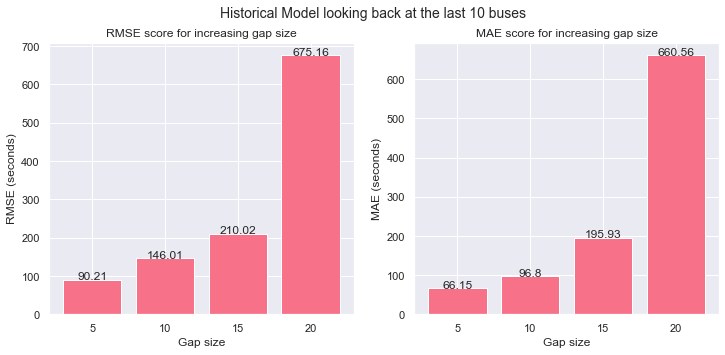

In [78]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

gap_labels = ["5", "10", "15", "20"]

ax[0].bar(gap_labels, rmses_gaps_10b)
ax[0].set_title("RMSE score for increasing gap size")
ax[0].set_xlabel("Gap size")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmseb = [round(rmses_gaps_10b[0], 2), round(rmses_gaps_10b[1], 2), round(rmses_gaps_10b[2], 2), round(rmses_gaps_10b[3], 2)]

for rect, label in zip(rects_rmse, labels_rmseb):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(gap_labels, mapes_gaps_10b)
ax[1].set_title("MAE score for increasing gap size")
ax[1].set_xlabel("Gap size")
ax[1].set_ylabel("MAE (seconds)")

rects_mape = ax[1].patches
labels_mapeb = [round(mapes_gaps_10b[0], 2), round(mapes_gaps_10b[1], 2), round(mapes_gaps_10b[2], 2), round(mapes_gaps_10b[3], 2)]

for rect, label in zip(rects_mape, labels_mapeb):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model looking back at the last 10 buses', fontsize=14)
plt.show()

In [79]:
# avg RMSE and MAE across different gaps

avg_rmse_10b = np.mean(rmses_gaps_10b)
avg_mape_10b = np.mean(mapes_gaps_10b)

print(avg_rmse_10b, avg_mape_10b)

%store avg_rmse_10b avg_mape_10b

280.35128133753784 254.8585640629152
Stored 'avg_rmse_10b' (float64)
Stored 'avg_mape_10b' (float64)
